In [136]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)  
library(apeglm)
library(ggrepel)

In [2]:
setwd('~/ownCloud/Meng/')

In [3]:
path <- "100_plus_project/100plus_data_Frank_2019-07-09/peptide data.tsv"
raw_data <- read.table(path, header=T, stringsAsFactors=F, sep = "\t")
#dim(raw_data)

In [4]:
dim(raw_data)

[1] 28208   476

In [5]:
peptide_quality <- raw_data[,c(1, 2, grep("qvalue_", colnames(raw_data)))]
peptide_intensity <- raw_data[,c(1, 2, grep("intensity_", colnames(raw_data)))]

In [6]:
##There are 4 peptides with missing value and 13 peptides does not have protein name
##So I remove them all
incomplete_peptide <- which(!complete.cases(peptide_intensity[3:ncol(peptide_intensity)]))
#incomplete_peptide
NA_protein <- which(is.na(peptide_quality$protein))
#NA_protein
peptide_quality <- peptide_quality[-c(union(NA_protein, incomplete_peptide)), ]
peptide_intensity <- peptide_intensity[-c(union(NA_protein, incomplete_peptide)), ]

In [7]:
dim(peptide_quality)
dim(peptide_intensity)

[1] 28191   239

[1] 28191   239

In [12]:
##remove samples with #(low quality peptide) > 34% 
threshold_1 = 0.34
cal_low_quality_num <- function(peptide_quality){
    return(length(which(peptide_quality>0.01)))
}
low_quality_num_psamp <- apply(peptide_quality[3:ncol(peptide_quality)], 2, cal_low_quality_num)
low_quality_num_psamp <- data.frame(num=low_quality_num_psamp)
low_quality_num_psamp$ratio <- low_quality_num_psamp$num / nrow(peptide_quality)
low_quality_sample_index <- which(low_quality_num_psamp$ratio > threshold_1)

In [38]:
high_quality_sample_index <- setdiff(3:ncol(peptide_intensity), low_quality_sample_index+2)

In [39]:
length(high_quality_sample_index)

[1] 202

In [14]:
##Start to perform filtering by distribution distance
all = as.vector(t(apply(log2(peptide_intensity[high_quality_sample_index]), 2, as.numeric)))
peptide_dist <- apply(peptide_intensity[,high_quality_sample_index], 2, function(intens_1sample){
    return (ks.test(log2(as.numeric(intens_1sample)), y=all, alternative="two.sided")$statistic)})
length(peptide_dist)

Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided

“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeri

“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeric(intens_1sample)), y = all, alternative = "two.sided"):
“p-value will be approximate in the presence of ties”Warning message in ks.test(log2(as.numeri

[1] 202

In [40]:
large_distribution_distance_index <- which(peptide_dist>0.04)
large_distribution_distance_samples_index <- high_quality_sample_index[large_distribution_distance_index]
large_distribution_distance_samples_index
high_quality_sample_index <- setdiff(high_quality_sample_index, large_distribution_distance_samples_index) 

[1] 107

In [41]:
length(high_quality_sample_index)

[1] 201

In [42]:
peptide_quality <- peptide_quality[c(1, 2, high_quality_sample_index)]
peptide_intensity <- peptide_intensity[c(1, 2, high_quality_sample_index)]

In [43]:
##aggregate function, aggregate peptides to protein for intensity using sum
##For quality using median
aggregate_peptide_protein_intensity <- function(peptide_intensity){
    protein_names <- unique(peptide_intensity$protein)
    protein_intensity <- matrix(0, length(protein_names), ncol(peptide_intensity)-2)
    for (i in 1:length(protein_names)){
        index <- which(peptide_intensity$protein == protein_names[i])
        pep2pro_intensity <- as.matrix(peptide_intensity[index,][3:ncol(peptide_intensity)])
        for (j in 1:ncol(pep2pro_intensity)){
            protein_intensity[i,][j] <- sum(pep2pro_intensity[,j])
        }
    }
    
    protein_intensity <- as.data.frame(protein_intensity)
    protein_intensity <- cbind(protein_names, protein_intensity)
    colnames_protein <- c("protein", colnames(peptide_intensity[3:ncol(peptide_intensity)]))
    colnames(protein_intensity) <- colnames_protein
    return(protein_intensity)
}
aggregate_peptide_protein_quality <- function(peptide_quality){
    protein_names <- unique(peptide_quality$protein)
    protein_quality <- matrix(0, length(protein_names), ncol(peptide_quality)-2)
    for (i in 1:length(protein_names)){
        index <- which(peptide_quality$protein == protein_names[i])
        pep2pro_quality <- as.matrix(peptide_quality[index,][3:ncol(peptide_quality)])
        for (j in 1:ncol(pep2pro_quality)){
            protein_quality[i,][j] <- median(pep2pro_quality[,j])
        }
    }
    
    protein_quality <- as.data.frame(protein_quality)
    protein_quality <- cbind(protein_names, protein_quality)
    colnames_protein <- c("protein", colnames(peptide_quality[3:ncol(peptide_quality)]))
    colnames(protein_quality) <- colnames_protein
    return(protein_quality)
}

In [44]:
protein_intensity <- aggregate_peptide_protein_intensity(peptide_intensity)
protein_quality <- aggregate_peptide_protein_intensity(peptide_quality)

In [47]:
dim(protein_quality)

[1] 4829  202

In [48]:
metadata <- read_excel("100_plus_project/Metadata/2019_07_23_Proteomics_Metadata_forMeng_v3.xlsx",sheet=1,col_names=TRUE, na="NA")
colnames(metadata)

names_sample <- as.array(colnames(protein_intensity)[2:ncol(protein_intensity)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
}

metadata <- metadata[filenames_map_index, ][c('nbb', 'Mass-Spec filenames (1)', 'Mass-Spec filenames (2)')]
metadata$inten_name <- colnames(protein_intensity)[-1]

New names:
* autopsy -> autopsy...3
* GROUP -> GROUP...4
* Snumber -> Snumber...8
* Snumber -> Snumber...16
* GROUP -> GROUP...17
* ...


[1] "nbb with colour code"                "nbb"                                
 [3] "autopsy...3"                         "GROUP...4"                          
 [5] "ABG"                                 "sampleprepRandomization (4 batches)"
 [7] "IHC order"                           "Snumber...8"                        
 [9] "zmRandomization (10 batches)"        "Mass-Spec filenames (1)"            
[11] "Mass-Spec filenames (2)"             "IHC nr"                             
[13] "Autopsy nr"                          "Diagnosis"                          
[15] "Date LCM"                            "Snumber...16"                       
[17] "GROUP...17"                          "IHC numbering"                      
[19] "tissuecode...19"                     "LCM slides"                         
[21] "LCM finished"                        "autopsy...22"                       
[23] "sex"                                 "age"                                
[25] "braak"                               "amyloid"                            
[27] "braaklb"                             "pmd"                                
[29] "ph"                                  "weight"                             
[31] "csf"                                 "apoe"                               
[33] "barcode"                             "id"                                 
[35] "tissuecode...35"                     "iduit"                              
[37] "datumuit"                            "uitvraag"                           
[39] "recipient"                           "clin. diagn."                       
[41] "dcode"                               "diagnosis"                          
[43] "dcodewk"                             "wcode"                              
[45] "region"                              "specific"                           
[47] "ocode"                               "storage"                            
[49] "freezer"                             "Clincal info"                       
[51] "...51"

In [49]:
dim(metadata)

[1] 201   4

In [50]:
nbb_count <- as.data.frame(table(metadata$nbb))
duplicate_nbb <- nbb_count[which(nbb_count$Freq > 1),]$Var1

In [51]:
length(duplicate_nbb)

[1] 11

In [52]:
duplicate_nbb_sample_index <- as.data.frame(lapply(duplicate_nbb, function(nbb){return (which(metadata$nbb == nbb))}))

In [53]:
duplicate_nbb_sample_index

c.21L..137L.,c.65L..123L.,c.120L..138L.,c.32L..74L.,c.16L..94L.,c.15L..81L.,c.121L..139L.,c.10L..187L.,c.95L..200L.,c.76L..189L.,c.42L..196L.
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
21,65,120,32,16,15,121,10,95,76,42
137,123,138,74,94,81,139,187,200,189,196


In [55]:
exclude_sample_index <- numeric(0)
for(i in 1:ncol(duplicate_nbb_sample_index)){
    if(t.test(peptide_quality[, duplicate_nbb_sample_index[,i][1]+2], alternative = "greater",
              peptide_quality[, duplicate_nbb_sample_index[,i][2]+2], paired = TRUE)$p.value < 0.05){
        
        print(t.test(peptide_quality[, duplicate_nbb_sample_index[,i][1]+2], alternative = "greater",
                     peptide_quality[, duplicate_nbb_sample_index[,i][2]+2], paired = TRUE)$p.value)
        print(colnames(peptide_quality)[duplicate_nbb_sample_index[,i][1]+2])
        print(colnames(peptide_quality)[duplicate_nbb_sample_index[,i][2]+2])
        
        exclude_sample_index <- c(exclude_sample_index, duplicate_nbb_sample_index[,i][1]+1)
    }
    else{
        
        print(t.test(peptide_quality[, duplicate_nbb_sample_index[,i][1]+2], alternative = "greater",
                     peptide_quality[, duplicate_nbb_sample_index[,i][2]+2], paired = TRUE)$p.value)
        print(colnames(peptide_quality)[duplicate_nbb_sample_index[,i][1]+2])
        print(colnames(peptide_quality)[duplicate_nbb_sample_index[,i][2]+2])
        
        exclude_sample_index <- c(exclude_sample_index, duplicate_nbb_sample_index[,i][2]+1)
    }
}

[1] 2.013779e-115
[1] "qvalue_20190326_28_S01_297_AD_018"
[1] "qvalue_20190424_169_S01_297_AD_165"
[1] 1
[1] "qvalue_20190412_170_S01_328_AD_082"
[1] "qvalue_20190419_44_01_328_AD_126"
[1] 9.22439e-12
[1] "qvalue_20190419_40_S02_231_AD_124"
[1] "qvalue_20190424_173_S02_231_AD_159"
[1] 1
[1] "qvalue_20190328_176_S03_150_AD_033"
[1] "qvalue_20190412_7_S03_150_AD_079"
[1] 3.037493e-10
[1] "qvalue_20190326_177_S04_062_AD_023"
[1] "qvalue_20190416_6_04_062_AD_111"
[1] 0.9999998
[1] "qvalue_20190326_176_S04_088_AD_021"
[1] "qvalue_20190415_64_04_088_AD_94"
[1] 1.056814e-77
[1] "qvalue_20190419_41_S07_116_AD_143"
[1] "qvalue_20190424_180_S07_116_AD_155"
[1] 1
[1] "qvalue_20190325_79_S07_308_ND_009"
[1] "qvalue_20190507_199_S07_308_ND_222"
[1] 0.9025106
[1] "qvalue_20190416_98_S08_153_ND_101_GOOD"
[1] "qvalue_20190606_98_S08_153_ND_RERUN"
[1] 1
[1] "qvalue_20190412_96_S11_039_ND_085"
[1] "qvalue_20190507_207_S11_039_ND_206"
[1] 0.9995865
[1] "qvalue_20190329_213_S12_049_ND_047"
[1] "qvalue_201

In [56]:
exclude_sample_index

[1]  22 124 121  75  17  82 122 188 201 190 197

In [57]:
protein_intensity <- protein_intensity[, -exclude_sample_index]
protein_quality <- protein_quality[, -exclude_sample_index]

In [59]:
colnames(peptide_intensity)[(exclude_sample_index+1)]

[1] "intensity_20190326_28_S01_297_AD_018"  
 [2] "intensity_20190419_44_01_328_AD_126"   
 [3] "intensity_20190419_40_S02_231_AD_124"  
 [4] "intensity_20190412_7_S03_150_AD_079"   
 [5] "intensity_20190326_177_S04_062_AD_023" 
 [6] "intensity_20190415_64_04_088_AD_94"    
 [7] "intensity_20190419_41_S07_116_AD_143"  
 [8] "intensity_20190507_199_S07_308_ND_222" 
 [9] "intensity_20190606_98_S08_153_ND_RERUN"
[10] "intensity_20190507_207_S11_039_ND_206" 
[11] "intensity_20190507_76_S12_049_ND_214"

In [61]:
peptide_quality <- peptide_quality[, -(exclude_sample_index+1)]

In [63]:
peptide_intensity <- peptide_intensity[, -(exclude_sample_index+1)]

In [139]:
#colnames(peptide_intensity)[-1] == colnames(protein_intensity)

In [67]:
dim(protein_intensity)
dim(protein_quality)
dim(peptide_intensity)
dim(peptide_quality)

[1] 4829  191

[1] 4829  191

[1] 28191   192

[1] 28191   192

In [91]:
log2_peptide_intensity <- log2(peptide_intensity[, -c(1, 2)])

In [92]:
peptide_info <- peptide_intensity[, c(1, 2)]

In [93]:
cal_weighted_protein_quality <- function(protein){
    intensity <- log2_peptide_intensity[which(peptide_info$protein == protein), ]
    quality <- peptide_quality[which(peptide_info$protein == protein), ][, -c(1, 2)]
    
    inten_mean <- rowMeans(intensity)
    #print(inten_mean)
    q_Lratio <- rowSums(quality >= 0.01)/ncol(quality)
    #print(q_Lratio)
    inten_fraction <- inten_mean/sum(inten_mean)
    #inten_fraction <- scale(inten_fraction, center = TRUE, scale = TRUE)
    #print(inten_fraction)
    return(sum(q_Lratio * inten_fraction))
}

cal_weighted_protein_quality("TOMM34")

[1] 0.5360991

In [95]:
protein_inten_quality <- as.data.frame(sapply(protein_intensity$protein, cal_weighted_protein_quality), 
                                       stringsAsFactors = FALSE)

In [96]:
colnames(protein_inten_quality) <- c("WQ")
protein_inten_quality$protein <- protein_intensity$protein
protein_inten_quality$X <- 1

In [97]:
length(which(protein_inten_quality$WQ > 0.5))

[1] 922

In [98]:
protein_WQ_g0.05 <- protein_inten_quality[protein_inten_quality$WQ > 0.5, ]$protein

In [106]:
peptide_quality_new <- peptide_quality[-which(peptide_quality$protein %in% as.character(protein_WQ_g0.05)), ]

In [112]:
peptide_intens_new <- peptide_intensity[-which(peptide_intensity$protein %in% as.character(protein_WQ_g0.05)), ]

In [113]:
dim(peptide_quality_new)
dim(peptide_intens_new)

[1] 26149   192

[1] 26149   192

In [114]:
length(unique(peptide_quality_new$protein))

[1] 3907

In [115]:
3907 + 922

[1] 4829

In [121]:
cal_prot_star_from_pept <- function(peptide_quality){
    protein_names <- unique(peptide_quality$protein)
    protein_star <- matrix(NA, 0, ncol(peptide_quality)-2)
    
    for (i in 1:length(protein_names)){
        index <- which(peptide_quality$protein == protein_names[i])
        pep2pro_quality <- as.matrix(peptide_quality[index,][3:ncol(peptide_quality)])
        protein_star <- rbind(protein_star, colSums(pep2pro_quality < 0.01))
    }
    protein_star <- as.data.frame(protein_star)
    
    colname <- as.vector(lapply(colnames(protein_star), function(names){return (paste("count", str_sub(names, 8), sep = "_"))}))

    colname <- c("protein", colname)
    protein_star <- cbind(protein_names, protein_star)
    colnames(protein_star) <- colname
    return(protein_star)
}

prot_star <- cal_prot_star_from_pept(peptide_quality)
protein_g90_index <- which(rowSums(prot_star[2:ncol(prot_star)]>0)/(ncol(prot_star)-1) >= 0.9)

In [122]:
length(protein_g90_index)

[1] 3556

In [123]:
protein_inten_quality <- as.data.frame(sapply(protein_intensity[protein_g90_index, ]$protein, cal_weighted_protein_quality), 
                                       stringsAsFactors = FALSE)

colnames(protein_inten_quality) <- c("WQ")
protein_inten_quality$protein <- protein_intensity[protein_g90_index, ]$protein
protein_inten_quality$X <- 1

length(which(protein_inten_quality$WQ > 0.5))

[1] 108

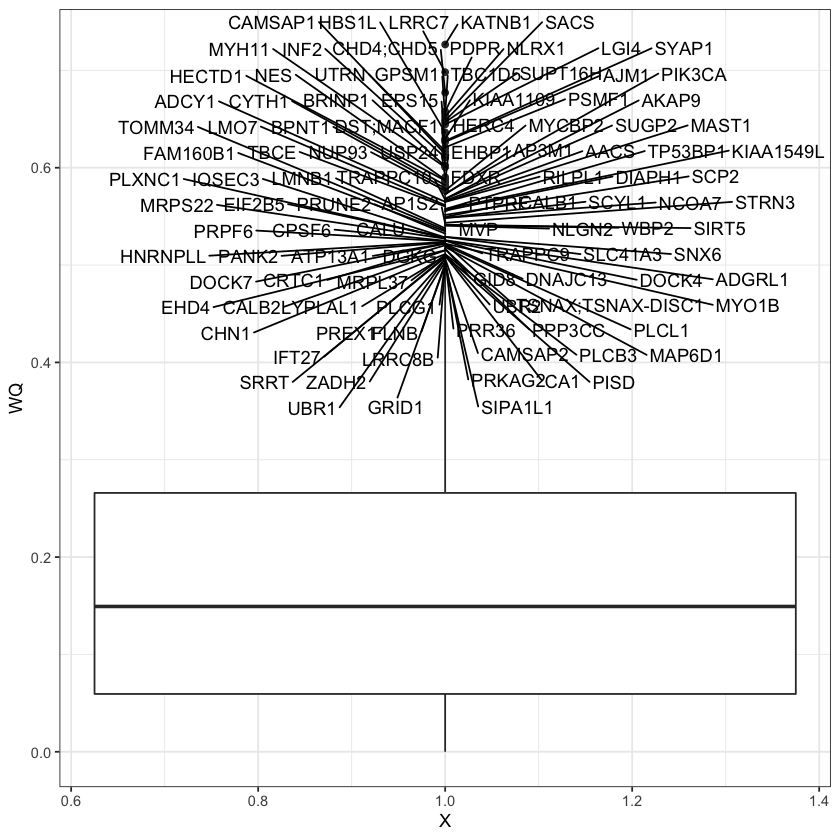

In [137]:
ggplot(protein_inten_quality, aes(y = WQ, x = X)) + 
    geom_boxplot() + 
    #geom_jitter(shape=15, position=position_jitter(0.2)) +
    geom_text_repel(aes(label=ifelse(WQ > 0.5, 
                             as.character(protein),''))) +
    theme_bw()

In [124]:
protein_intensity[protein_g90_index[-which(protein_inten_quality$WQ > 0.5)], ]

,protein,intensity_20190325_121_S16_020_CHC_011,intensity_20190325_125_S16_044_CHC_007,intensity_20190325_127_S16_094_CHC_004,intensity_20190325_16_04_037_AD_008,intensity_20190325_183_S10_292_AD_010,intensity_20190325_194_S02_055_ND_005,intensity_20190325_31_01_184_AD_006,intensity_20190325_57_S97_235_AD_003,intensity_20190325_77_S11_072_ND_012,⋯,intensity_20190507_21_01_032_AD_221,intensity_20190507_27_00_204_AD_211,intensity_20190507_29_S99_240_AD_219,intensity_20190507_30_S05_040_AD_209,intensity_20190507_63_04_027_AD_217,intensity_20190507_72_S99_219_AD_213,intensity_20190606_106_NABCA14_08_ND_RERUN,intensity_20190606_140_2017_027_CHC_RERUN,intensity_20190606_20_S00_166_AD_RERUN,intensity_20190606_9_S93_025_AD_RERUN
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SLC12A2,836.80987,881.06951,780.98996,701.68957,1245.36392,1264.51784,795.12072,810.26815,729.90767,⋯,917.08439,851.88556,796.88906,663.22765,941.54816,932.08231,1052.79254,917.45960,813.67832,865.75086
2,CASKIN1,1344.34121,1049.89367,951.79843,904.19465,651.40811,1497.91167,667.30437,865.30500,1022.58727,⋯,753.06675,692.13651,507.57334,1103.08975,693.45142,874.55879,900.35601,786.30930,1033.71160,805.19428
4,GNG2,563.31659,208.31086,350.94199,232.02806,210.62083,242.26756,161.09872,218.97718,377.72039,⋯,183.91086,133.00780,153.79479,229.45112,256.21317,195.04436,164.62043,179.79677,190.60729,213.85196
5,CARNS1,33.40392,75.57282,98.33277,23.09145,307.11463,101.08390,99.64686,112.03207,42.20178,⋯,55.58988,164.73288,49.12562,29.13836,139.90373,53.68109,93.04210,134.53807,104.82207,119.33094
6,FH,3326.60924,4564.59875,5238.09499,3906.98843,3662.44502,2009.79815,4318.91514,4116.81168,3991.92090,⋯,5109.84351,3684.03726,4991.14490,3601.41144,3848.70803,4560.84202,4917.91263,4758.63636,4190.09930,5038.00332
7,EFHD2,508.48022,571.96033,1722.07907,406.67353,543.35073,303.94769,783.93013,1165.80121,602.14280,⋯,712.87081,802.54044,890.61294,375.67400,657.88005,1211.05592,1528.88668,1777.48636,945.07368,1577.98572
9,PCLO,2369.33932,1029.75211,954.52388,1652.92346,1520.51650,2583.51659,1804.85497,1677.07029,2357.03278,⋯,2564.36720,1907.63409,2410.77471,2943.85799,831.38952,2446.47573,3547.34325,3332.46509,2784.91200,3311.11634
10,HSPA1A;HSPA1B,7124.78872,6129.39109,7834.88395,6527.18995,11445.45274,5029.23535,9876.28243,10660.13041,5758.54005,⋯,7159.83303,10712.43211,10114.79332,7628.30538,6270.58343,10350.33344,8784.79637,8276.78113,8458.72235,10499.10328
11,STIP1,1028.55835,767.89888,2651.63959,988.76516,1302.06611,334.72548,1739.11160,2405.02599,774.17336,⋯,1464.82937,1376.75255,1398.01876,1322.92881,1183.51846,1722.29743,2017.77206,1685.91565,1494.30325,2335.50754


In [119]:
protein_intensity_new <- aggregate_peptide_protein_intensity(peptide_intens_new)

In [120]:
protein_intensity_new <- protein_intensity_new[protein_g90_index, ]

In [129]:
sum(as.character(protein_intensity_new$protein) == as.character(protein_intensity[protein_g90_index[-which(protein_inten_quality$WQ > 0.5)], ]$protein))

[1] 3448

In [132]:
dim(protein_intensity)
dim(prot_star[-protein_g90_index[-which(protein_inten_quality$WQ > 0.5)],])
dim(protein_intensity[protein_g90_index[-which(protein_inten_quality$WQ > 0.5)], ])

[1] 4829  191

[1] 1381  191

[1] 3448  191

In [133]:
write.table(protein_intensity[protein_g90_index[-which(protein_inten_quality$WQ > 0.5)], ], file = "R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv", append = FALSE, quote = FALSE, 
            sep = "\t", eol = "\n", na = "NA", dec = ".", row.names = FALSE, col.names = TRUE)

In [134]:
write.table(prot_star[-protein_g90_index[-which(protein_inten_quality$WQ > 0.5)],], file = "R_workstation/100_plus_proteomic_DATA/Low_quality_protein_good_measurement_count_matrix.tsv", append = FALSE, quote = FALSE, 
            sep = "\t", eol = "\n", na = "NA", dec = ".", row.names = FALSE, col.names = TRUE)

In [2]:
prot_star <- read.table("/Users/zhangmeng/ownCloud/Meng/R_workstation/100_plus_proteomic_DATA/Low_quality_protein_good_measurement_count_matrix.tsv",  
            sep = "\t", head = TRUE)